# Power tree diagrams
`sysLoss` can produce graphical power tree diagrams from a system, and this notebook will take you through the process including how to customize the look of the diagram.


In [1]:
# This cell can be removed, it is only used for running the notebook during Sphinx documentation build.
import sys, os
if os.getcwd().replace('\\', '/').endswith("/docs/nb"):
    sys.path.insert(0, os.path.abspath(os.path.join("../../src")))

Import packages:

In [2]:
from sysloss.components import *
from sysloss.system import System
import sysloss.diagram as sd

Graphviz needs to be installed before using `sysLoss` diagrams. When running `sysLoss` in an anaconda environment, Graphviz is installed simply with:<br>`conda install anaconda::graphviz`.<br>

Otherwise follow instructions on [grapviz.org](https://graphviz.org/).

## System definition
Start by defining a system for analysis, in this case a relay and light control module powered from 48V.

In [3]:
rcm = System("Relay control module", Source("48V", vo=48, rs=0.01, limits={"io":[0, 2]}))
rcm.add_comp("48V", comp=RLoss("Fuse", rs=30e-3, limits={"io":[0, 2]}))
rcm.add_comp("Fuse", comp=Converter("12V buck", vo=12, eff=0.85, limits={"io":[0, 8]}))
rcm.add_comp("12V buck", comp=PSwitch("Load switch 1", rs=0.055, ig=10e-6))
rcm.add_comp("12V buck", comp=PSwitch("Load switch 2", rs=0.055, ig=10e-6))
rcm.add_comp("12V buck", comp=PSwitch("Load switch 3", rs=0.055, ig=10e-6))
rcm.add_comp("12V buck", comp=PSwitch("Load switch 4", rs=0.055, ig=10e-6))
rcm.add_comp("Load switch 1", comp=PLoad("LED array", pwr=3.7))
rcm.add_comp("Load switch 2", comp=RLoad("Relay 1", rs=180, loss=True), group="Relay board")
rcm.add_comp("Load switch 3", comp=RLoad("Relay 2", rs=180, loss=True), group="Relay board")
rcm.add_comp("Load switch 4", comp=RLoad("Relay 3", rs=180, loss=True), group="Relay board")
rcm.add_comp("12V buck", comp=Converter("3.3V buck", vo=3.3, eff=0.76, limits={"io":[0,2]}))
rcm.add_comp("3.3V buck", comp=LinReg("2.5V LDO", vo=2.5, limits={"io":[0,0.45]}))
rcm.add_comp("3.3V buck", comp=PLoad("MCU I/O", pwr=0.1), group="MCU")
rcm.add_comp("2.5V LDO", comp=PLoad("MCU I/O 2", pwr=0.15), group="MCU")
rcm.add_comp("2.5V LDO", comp=PLoad("Flash memory", pwr=0.066))
rcm.add_comp("3.3V buck", comp=Converter("1.2V buck", vo=1.2, eff=0.88, limits={"io":[0,0.5]}))
rcm.add_comp("1.2V buck", comp=ILoad("MCU core", ii=0.1), group="MCU")

The text-based tree() method:

In [4]:
rcm.tree()

Relay control module
└── 48V
    └── Fuse
        └── 12V buck
            ├── 3.3V buck
            │   ├── 1.2V buck
            │   │   └── MCU core
            │   ├── MCU I/O
            │   └── 2.5V LDO
            │       ├── Flash memory
            │       └── MCU I/O 2
            ├── Load switch 4
            │   └── Relay 3
            ├── Load switch 3
            │   └── Relay 2
            ├── Load switch 2
            │   └── Relay 1
            └── Load switch 1
                └── LED array

## Graphics diagram
`sysloss` is using Graphviz to render power tree diagrams. A graphics power tree diagram in top-bottom format is created with the function `make_diag()`, which returns a PIL.Image object.

```{note}
It is not possible to position lines between components, this is automatic by Graphviz. There are some attributes that influence how lines are drawn, see Graphviz documentation.
```

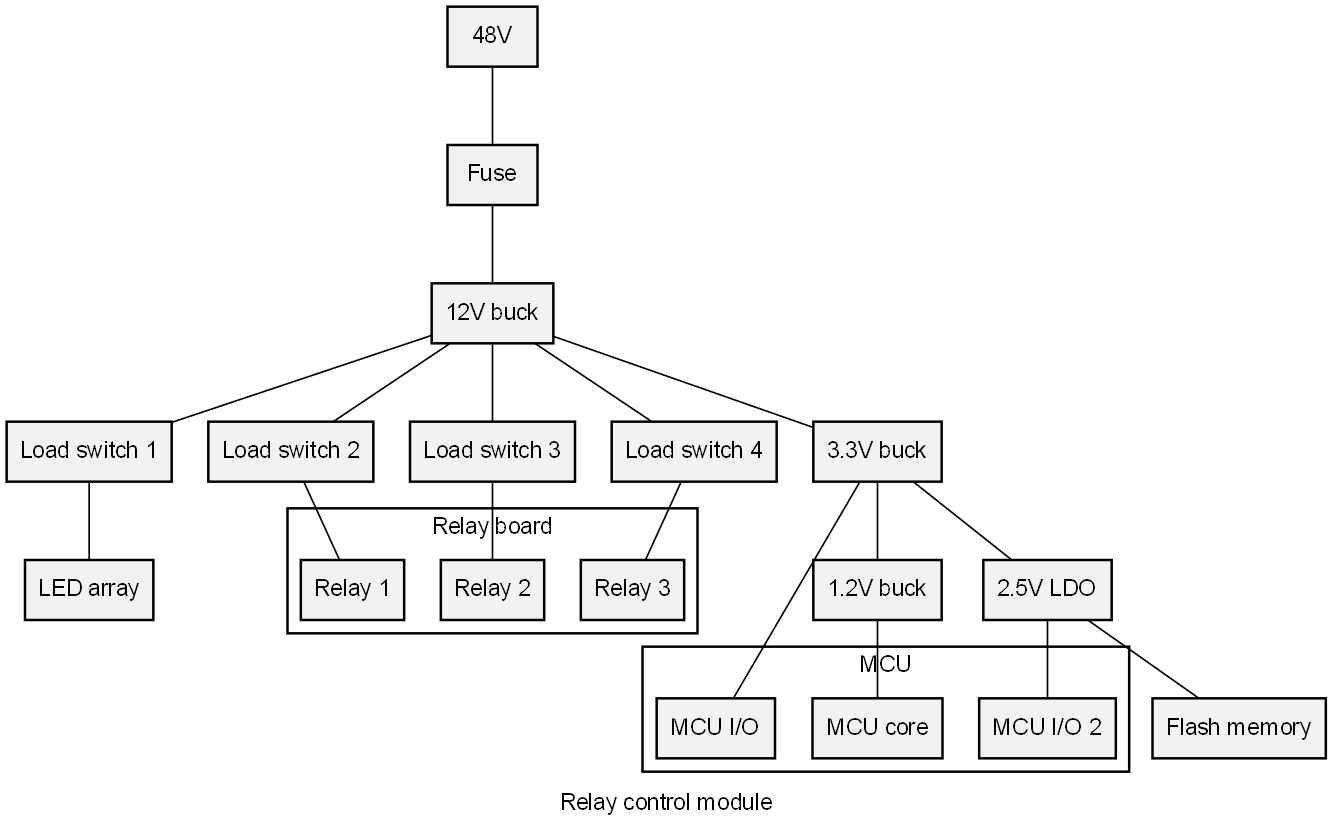

In [5]:
sd.make_diag(rcm)

The diagram can also be written directly to file by using the `fname` argument, the file extension defines the file format. 
```{tip}
Use .png or .svg for best quality, .jpg is not recommended.
```

In [6]:
sd.make_diag(rcm, fname="control_module.svg")

## Customize the diagram
The power tree diagram can be customized using different Graphviz attributes. Familiarity with Graphviz is required to fully utilize the many attributes available.<br>
The attributes used by `sysLoss` are:
  * Overall diagram: [Graph attributes](https://graphviz.org/docs/graph/)
  * Groups: [Cluster attributes](https://graphviz.org/docs/clusters/)
  * Components: [Node attributes](https://graphviz.org/docs/nodes/)
  * Lines: [Edge attributes](https://graphviz.org/docs/edges/)

The default Graphviz attributes used by `sysLoss` are defined in a Python dictionary, obtained by a call to the function `get_conf()`: 

In [7]:
my_conf = sd.get_conf()
my_conf

{'graph': {'rankdir': 'TB',
  'ranksep': '0.3 equally',
  'splines': 'line',
  'nodesep': '0.3',
  'overlap': 'scale',
  'dpi': '120',
  'fontname': 'arial',
  'fontcolor': 'black'},
 'cluster': {'default': {'rank': 'same',
   'fillcolor': 'white',
   'style': 'filled',
   'penwidth': '1.5',
   'fontname': 'arial',
   'fontcolor': 'black'}},
 'node': {'default': {'fillcolor': 'gray95',
   'style': 'filled',
   'shape': 'box',
   'penwidth': '1.5',
   'fontname': 'arial',
   'fontcolor': 'black'}},
 'edge': {'arrowhead': 'none',
  'headport': 'center',
  'tailport': 'center',
  'color': 'black'}}

Let's start by changing the layout from top-bottom to left-right:

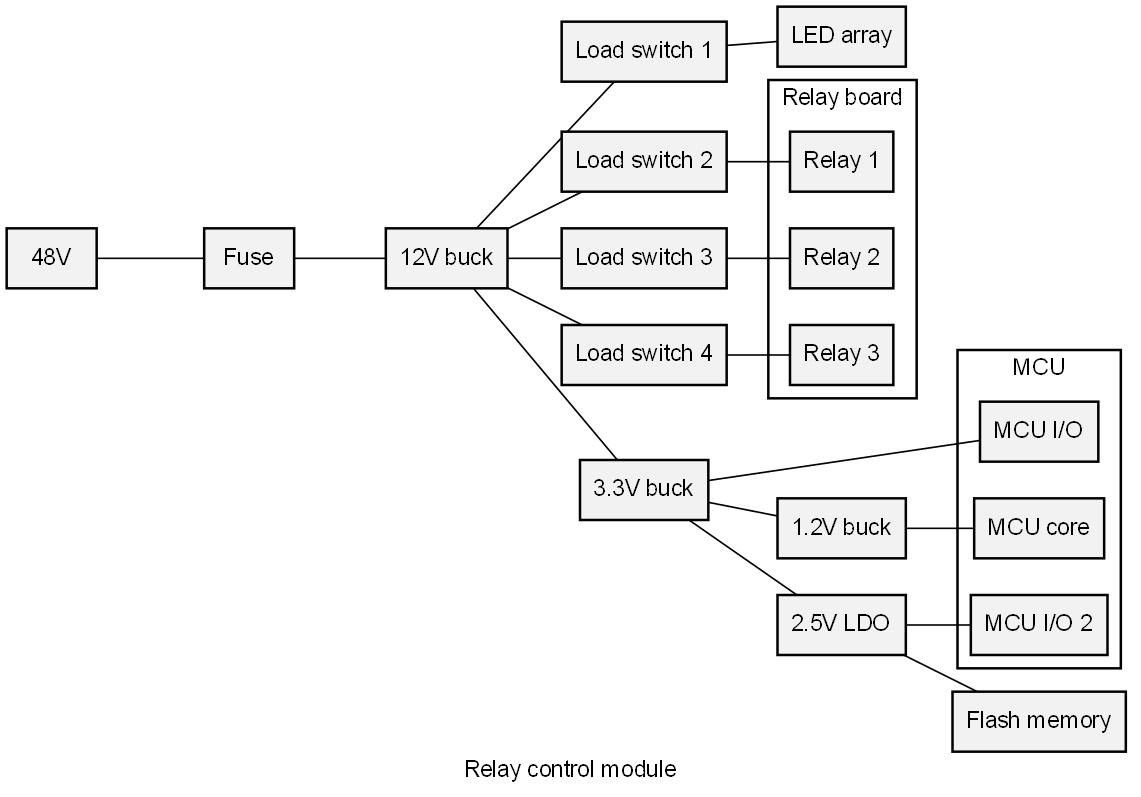

In [8]:
my_conf["graph"]["rankdir"] = 'LR'
sd.make_diag(rcm, config=my_conf)

The lines can be changed to orthogonal type:

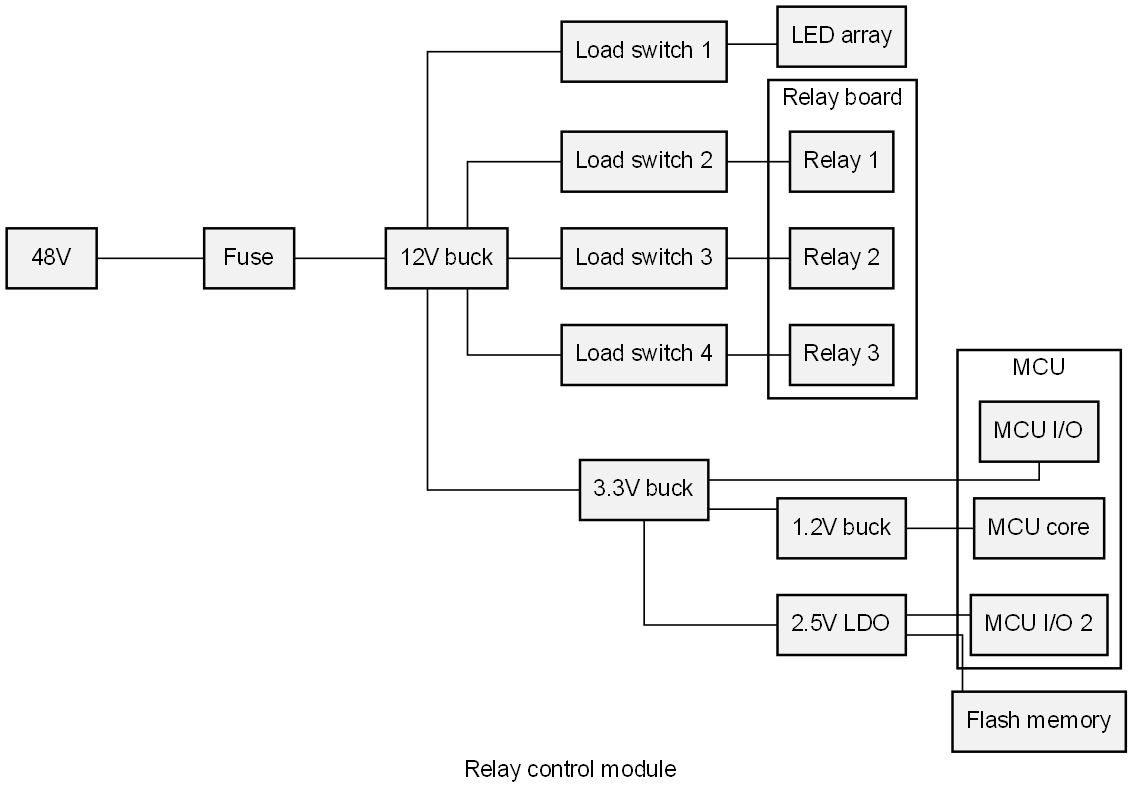

In [9]:
my_conf["graph"]['splines']="ortho"
sd.make_diag(rcm, config=my_conf)

Component shape, color etc. can be customized by component type. Let's change the source shape to be round:

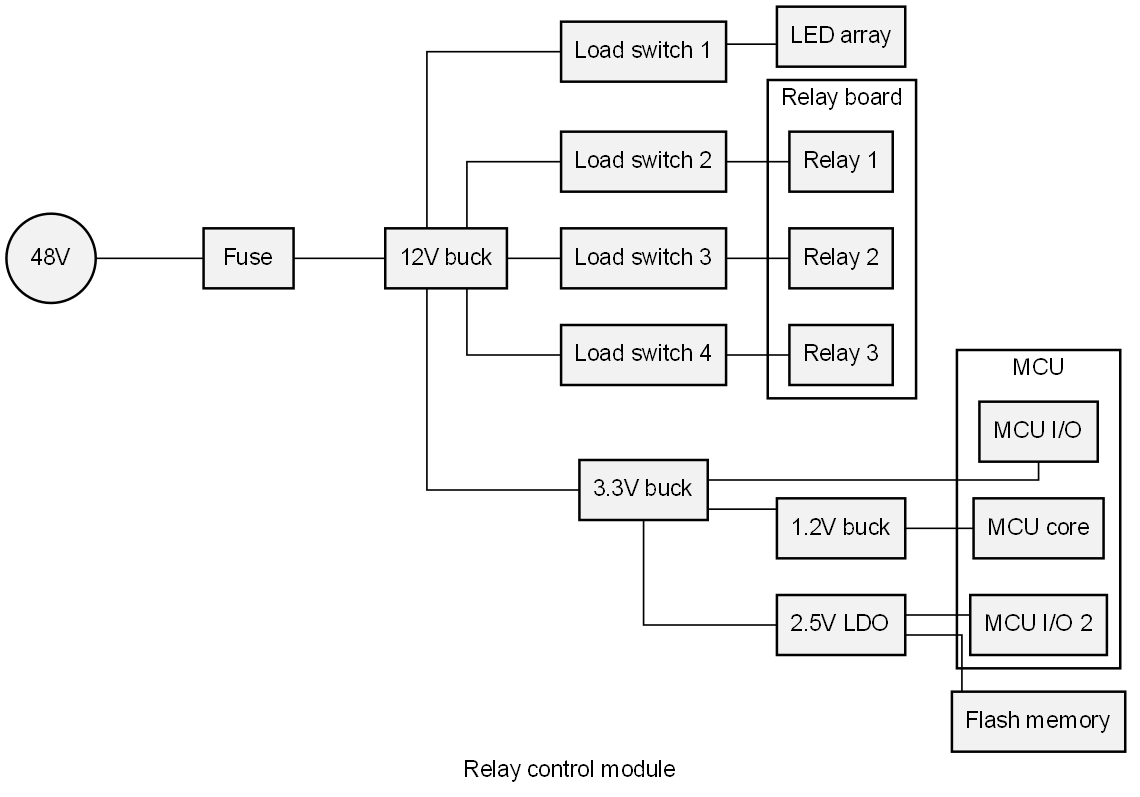

In [10]:
my_conf["node"]["Source"] = {"shape":"circle"}
sd.make_diag(rcm, config=my_conf)

We can also add individual colors to each component type, groups or even individual components:

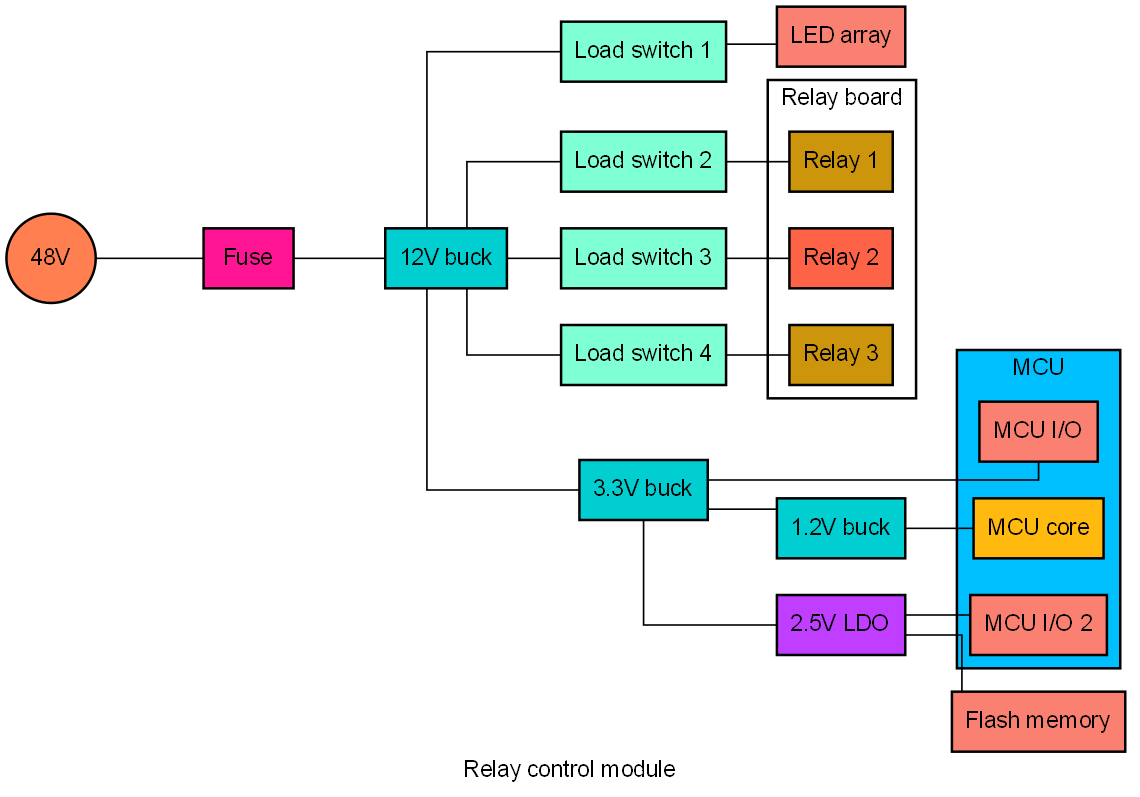

In [11]:
my_conf["node"]["Source"] = {"shape":"circle", "fillcolor":"coral"}
my_conf["node"]["Converter"] = {"fillcolor":"darkturquoise"}
my_conf["node"]["ILoad"] = {"fillcolor":"darkgoldenrod1"}
my_conf["node"]["PLoad"] = {"fillcolor":"salmon"}
my_conf["node"]["RLoad"] = {"fillcolor":"darkgoldenrod3"}
my_conf["node"]["RLoss"] = {"fillcolor":"deeppink"}
my_conf["node"]["LinReg"] = {"fillcolor":"darkorchid1"}
my_conf["node"]["PSwitch"] = {"fillcolor":"aquamarine"}
my_conf["node"]["Relay 2"] = {"fillcolor":"tomato1"}
my_conf["cluster"]["MCU"]= {"fillcolor" :"deepskyblue"}
sd.make_diag(rcm, config=my_conf)

Lines can also be modified, let's add an arrowhead:

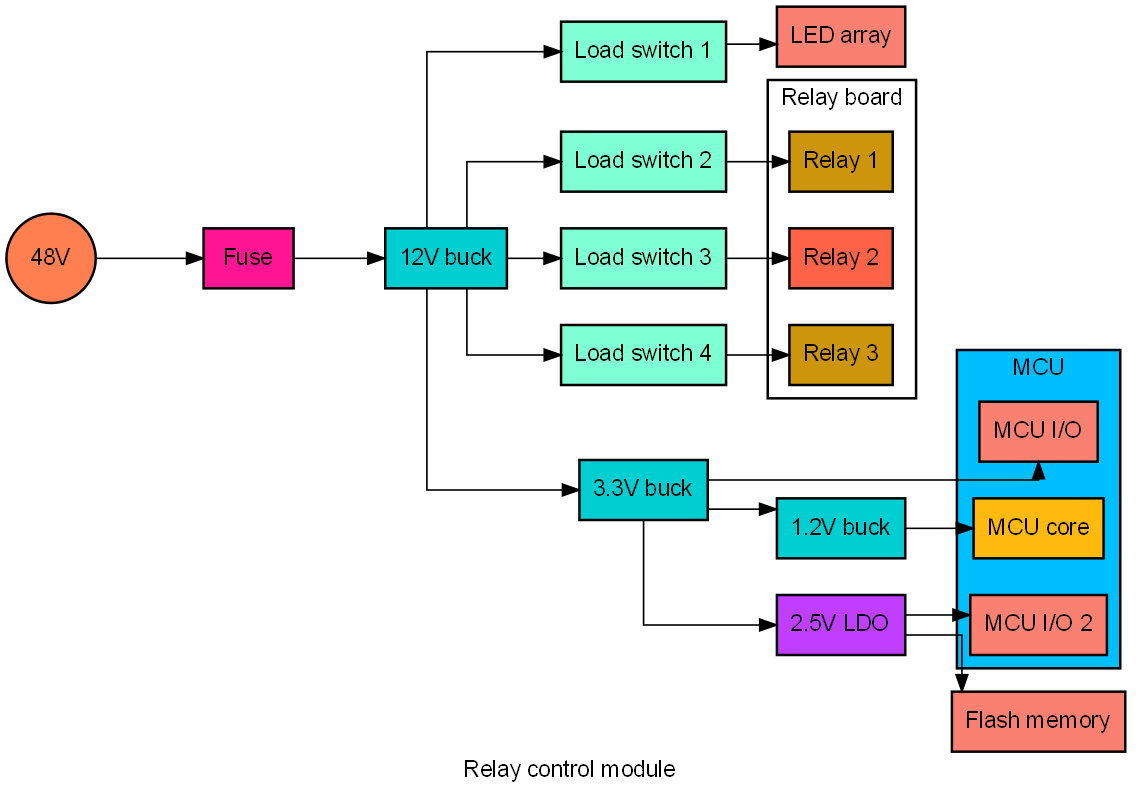

In [12]:
my_conf["edge"]["arrowhead"] = "normal"
sd.make_diag(rcm, config=my_conf)

```{tip}
Grouping can be disabled by setting the `group` parameter to False.
```

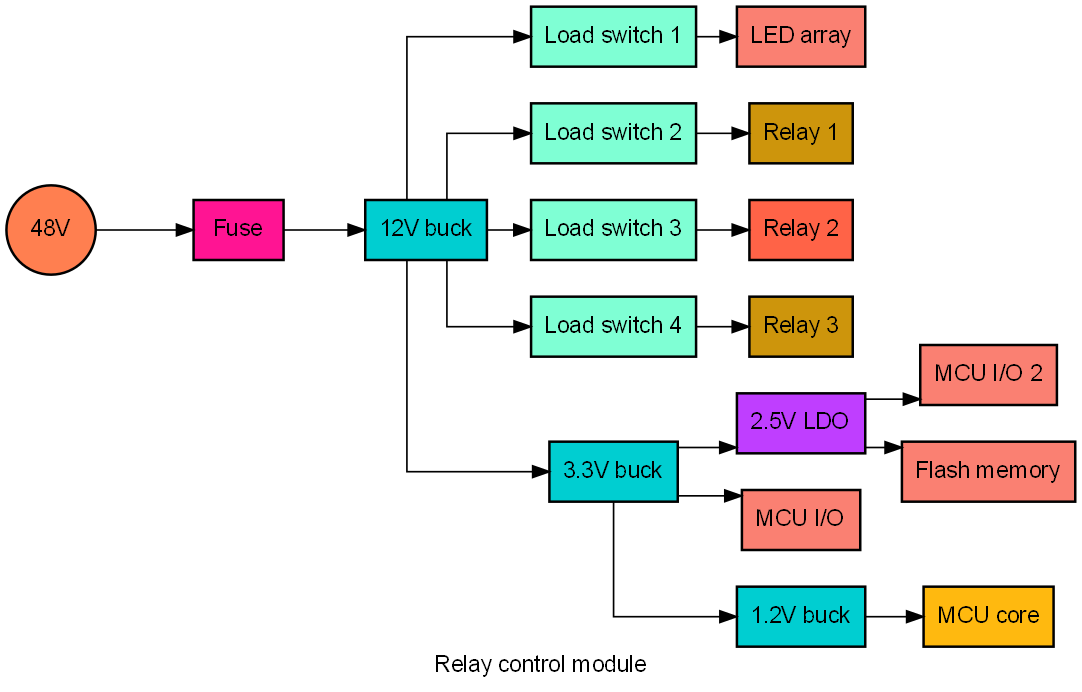

In [13]:
sd.make_diag(rcm, group=False, config=my_conf)

## Heat diagram
`sysloss` can also generate heat diagrams, showing the power tree with gradient-colored components. Components are also annotated with the loss in Watts. The system is solved before the diagram is made.

```{note}
If system load phases have been defined, the weighted average loss is used in the heat diagram. Component colors are overridden with gradient colors, other configurations are kept.
```

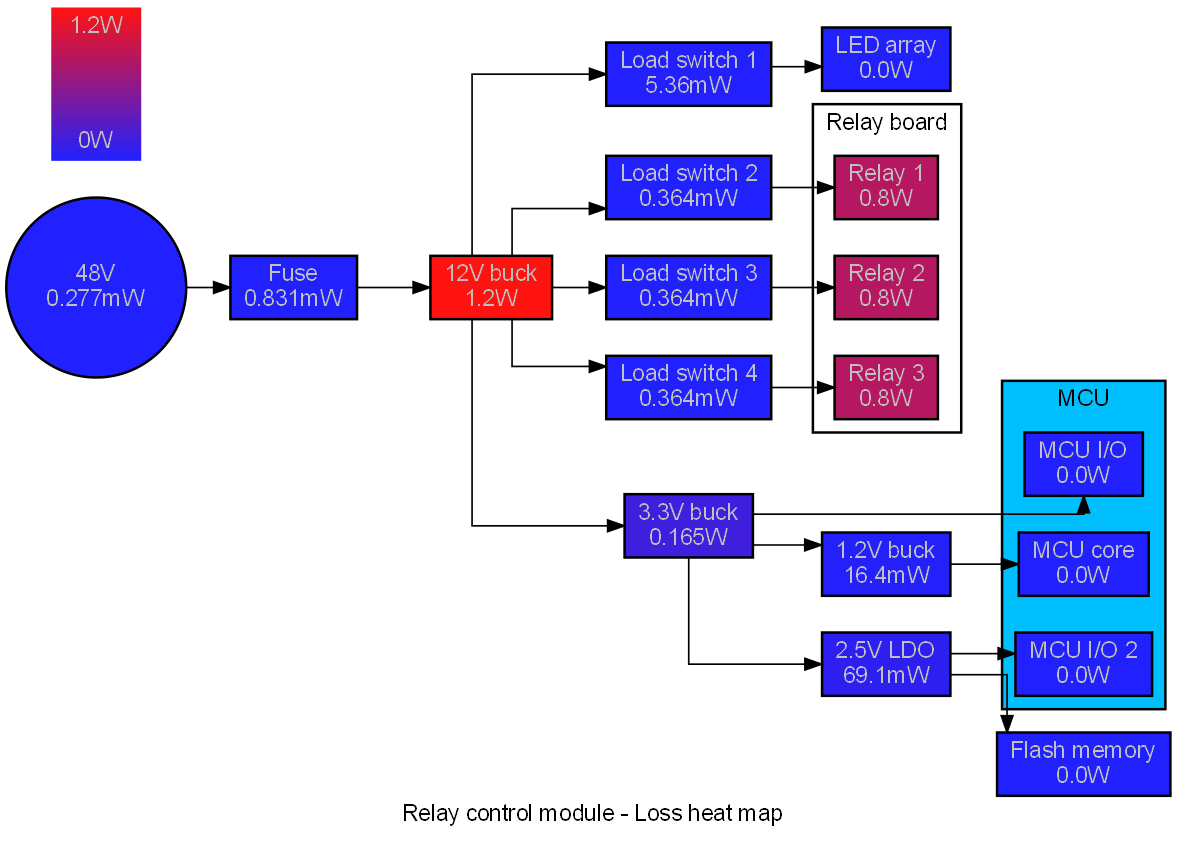

In [14]:
sd.make_hdiag(rcm, config=my_conf)

## Summary
Power tree diagrams are created using functions from the `diagram` package. The diagrams can be customized with Graphviz attributes.